# Kewaord search

# Setup
Load needed API keys and relevant Python libaries.

In [9]:
# !pip install dotenv
# !pip install -U weaviate-client

In [3]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file

Start by imporing Weaviate to access the Wikipedia database

In [5]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key="76320a90-53d8-42bc-b41d-678647c6672e")

# 76320a90-53d8-42bc-b41d-678647c6672e

In [6]:
client = weaviate.Client(
    url="https://cohere-demo.weaviate.network/",
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": "f25TSVZu9ltUtKteb1wmeKRPeSyaAUIEJ91LMa5a"
    }
)

C:\Users\bouchekir\Anaconda3\envs\AssARG\lib\site-packages\weaviate\warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration
            
  warnings.warn(


In [7]:
client.is_ready()

True

# Keyword Search

In [12]:
def keyword_search(query, 
                   result_lang='en', 
                   properties=["title", "url", "text"],
                   num_results = 3):
    
    where_filter={
        "path":["lang"],
        "operator":"Equal",
        "valueString": result_lang
    }
    
    response = (
        client.query.get("Articles", properties)
        .with_bm25(
            query=query
        )
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
    )
    
    
    result = response['data']['Get']['Articles']
    return result

In [14]:
def print_result(result):
    for i, item in enumerate(result):
        print(f'item {i}')
        for key in item.keys():
            print(f'{key}:{item.get(key)}')
            print()
        print()

In [16]:
query = " What is Algeria? "
keyword_search_results = keyword_search(query)
print_result(keyword_search_results)

item 0
text:Before the war, Algeria was a popular setting for French films; the British professor Leslie Hill having written: "In the late 1920s and 1930s, for instance, North Africa provided film-makers in France with a ready fund of familiar images of the exotics, mingling, for instance, the languid eroticism of Arabian nights with the infinite and hazy vistas of the Sahara to create a powerful confection of tragic heroism and passionate love". During the war itself, French censors banned the entire subject of the war. Since 1962, when film censorship relating to the war eased, French films dealing with the conflict have consistently portrayed the war as a set of conflicting memories and rival narratives (which ones being correct are left unclear), with most films dealing with the war taking a disjointed chronological structure in which scenes before, during and after the war are juxtaposed out of sequence with one film critic referring to the cinematic Algeria as "an ambiguous world

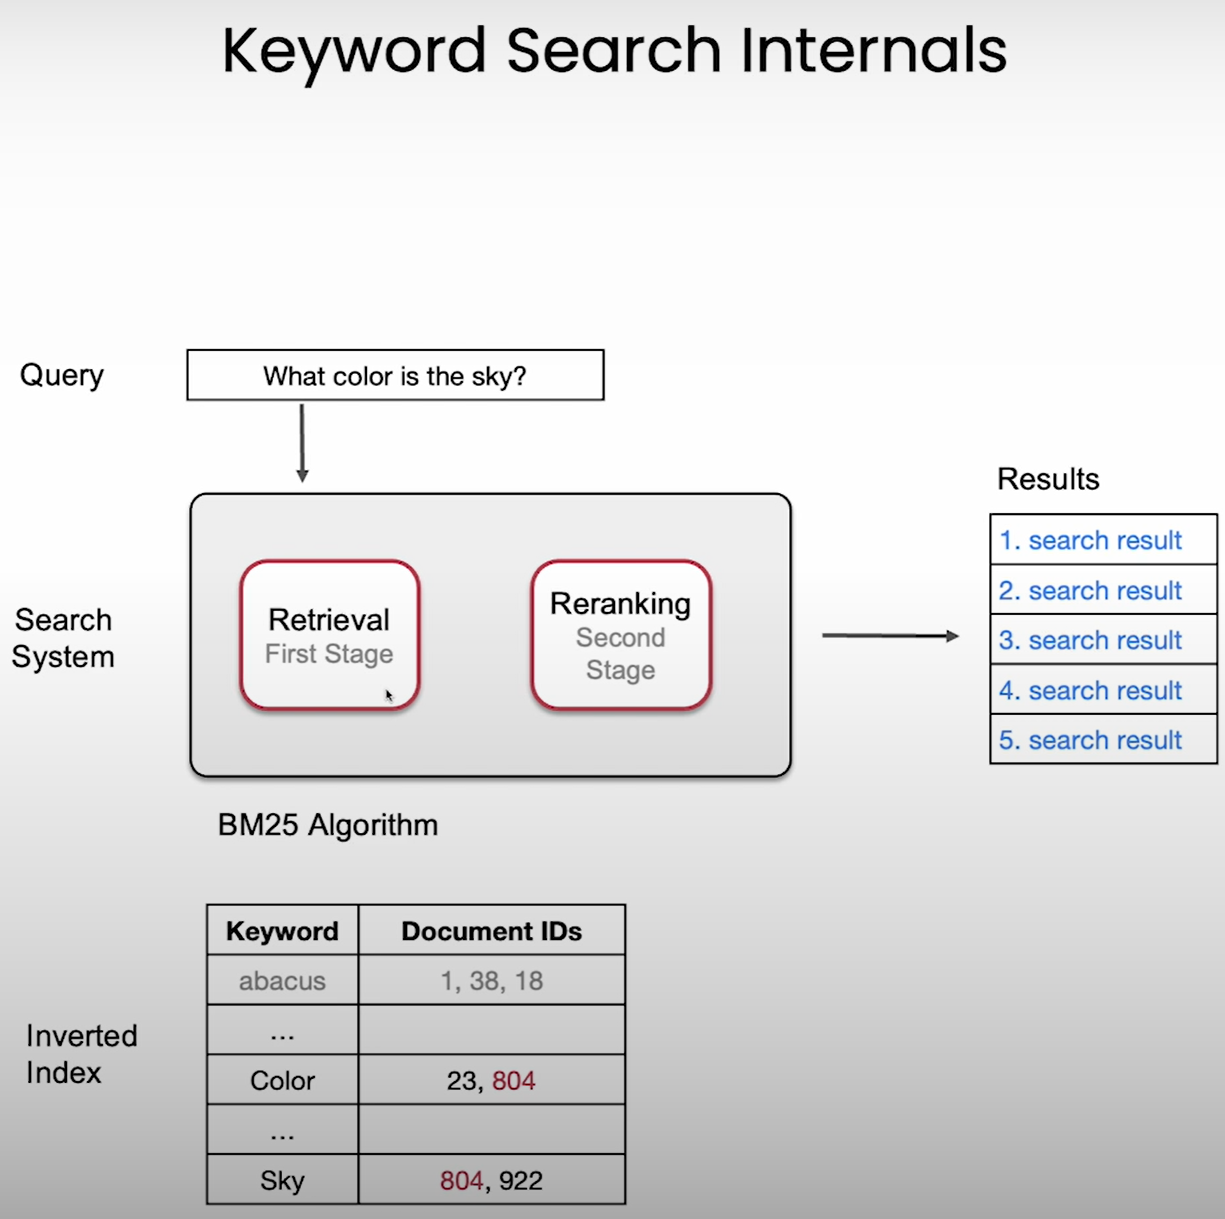

# BM25S Algorithm

https://github.com/xhluca/bm25s/tree/main?tab=readme-ov-file

In [18]:
# !pip install bm25s

In [21]:
import bm25s
import Stemmer # optional: for stemming

In [22]:
# Create your corpus here
corpus = [
    "a cat is a feline and likes to purr",
    "a dog is the human's best friend and loves to play",
    "a bird is a beautiful animal that can fly",
    "a fish is a creature that lives in water and swims",
]

In [23]:
# optional: create a stemmer
stemmer = Stemmer.Stemmer("english")

In [25]:
# Tokenize the corpus and only keep the ids (faster and saves memory)
corpus_tokens = bm25s.tokenize(corpus, stopwords="en", stemmer=stemmer)
print(corpus_tokens)

Split strings:   0%|          | 0/4 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/4 [00:00<?, ?it/s]

Tokenized(ids=[[15, 6, 18, 8], [10, 3, 4, 14, 1, 7], [13, 17, 19, 11, 5], [16, 0, 9, 2, 12]], vocab={'creatur': 0, 'love': 1, 'water': 2, 'human': 3, 'best': 4, 'fli': 5, 'felin': 6, 'play': 7, 'purr': 8, 'live': 9, 'dog': 10, 'can': 11, 'swim': 12, 'bird': 13, 'friend': 14, 'cat': 15, 'fish': 16, 'beauti': 17, 'like': 18, 'anim': 19})


In [26]:
# Create the BM25 model and index the corpus
retriever = bm25s.BM25()
retriever.index(corpus_tokens)

BM25S Count Tokens:   0%|          | 0/4 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
# Query the corpus
query = "does the fish purr like a cat?"
query_tokens = bm25s.tokenize(query, stemmer=stemmer)

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# Get top-k results as a tuple of (doc ids, scores). Both are arrays of shape (n_queries, k)
results, scores = retriever.retrieve(query_tokens, corpus=corpus, k=2)

for i in range(results.shape[1]):
    doc, score = results[0, i], scores[0, i]
    print(f"Rank {i+1} (score: {score:.2f}): {doc}")

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Rank 1 (score: 1.59): a cat is a feline and likes to purr
Rank 2 (score: 0.48): a fish is a creature that lives in water and swims


In [29]:
# You can save the arrays to a directory...
retriever.save("animal_index_bm25")

In [30]:
# You can save the corpus along with the model
retriever.save("animal_index_bm25", corpus=corpus)

Finding newlines for mmindex:   0%|          | 0.00/268 [00:00<?, ?B/s]

In [31]:
# ...and load them when you need them
import bm25s
reloaded_retriever = bm25s.BM25.load("animal_index_bm25", load_corpus=True)
# set load_corpus=False if you don't need the corpus